In this notebook we show how to use the Pytorch SDO dataset and the data loader to pass the SDO dataset in batches to a NN model. **Last updated 19th July 2019.**

In [1]:
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from matplotlib.pyplot import imshow

import torch
from torch import nn, optim
from sdo.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sdo.models.encoder_decoder import AutoEncoder

%matplotlib inline

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [3]:
# we tried with a few of channels combinations, the larger the difference in absolute values beetween channels, 
# the more problematic the convergence (see spikes below) with ['0171', '0193', '0094'] being the worst
# of the 3 combinations
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
#instr = ['AIA', 'AIA', 'AIA']
#channels = ['0171', '0193', '0094']
#instr = ['AIA', 'AIA']
#channels = ['0171', '0193']
instr = ['AIA', 'AIA', 'AIA']
channels = ['0171', '0193', '0304']

In [4]:
#some cuda initialization
torch.backends.cudnn.enabled = True
cuda_device = 1
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
device, torch.cuda.current_device(), torch.cuda.device_count()))

Using device cuda:1 for training, current device: 0, total devices: 6


In [5]:
# after some discussion we found scaling seems the more appropriate choice
# with the following choice of parameters we are selecting one image for day
# November and Dicember are not available because we are keeping them as holdout
train_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2011, 2018], 
                         mnt_step=1, day_step=1, h_step=25, min_step=61, subsample=subsample, 
                         test_ratio= 0.3, normalization=0, scaling=True)
test_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2011, 2018], 
                        mnt_step=1, day_step=1, h_step=25, min_step=61, subsample=subsample, 
                        test_ratio= 0.3, normalization=0, scaling=True, test=True)

[2019-07-20 18:12:02] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-20 18:12:02] INFO:sdo.sdo_dataset:Running on months "[1 2 3 4 5 6 7]"
[2019-07-20 18:12:12] INFO:sdo.sdo_dataset:Number of found timestamps = 1664
[2019-07-20 18:12:12] INFO:sdo.sdo_dataset:Number of discarded timestamps = 72
[2019-07-20 18:12:12] INFO:sdo.sdo_dataset:Number of SDO files = 4992
[2019-07-20 18:12:12] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-20 18:12:12] INFO:sdo.sdo_dataset:Running on months "[ 8  9 10]"
[2019-07-20 18:12:22] INFO:sdo.sdo_dataset:Number of found timestamps = 702
[2019-07-20 18:12:22] INFO:sdo.sdo_dataset:Number of discarded timestamps = 42
[2019-07-20 18:12:22] INFO:sdo.sdo_dataset:Number of SDO files = 2106


In [6]:
train_data_loader = DataLoader(train_data, batch_size=10, shuffle=True)

0 torch.Size([10, 3, 512, 512])
0171
tensor(4.5650, device='cuda:1') tensor(0., device='cuda:1')
tensor([[2.2553e-04, 2.5183e-04, 3.7824e-04,  ..., 3.6868e-04, 0.0000e+00,
         2.2371e-04],
        [1.9298e-04, 3.0681e-04, 3.2384e-04,  ..., 2.5857e-04, 1.9935e-05,
         9.5151e-05],
        [1.1680e-04, 5.9020e-04, 1.0805e-04,  ..., 1.4412e-04, 2.8568e-04,
         2.5915e-04],
        ...,
        [2.9546e-04, 1.9470e-04, 3.2382e-04,  ..., 2.8467e-04, 3.5171e-04,
         3.7994e-04],
        [7.9739e-05, 3.0105e-04, 3.6644e-04,  ..., 3.5134e-04, 3.2750e-04,
         3.6895e-04],
        [2.1755e-04, 3.0800e-04, 1.1961e-04,  ..., 2.9146e-04, 2.0142e-04,
         2.4676e-04]], device='cuda:1')
4.5650477 0.0 0.2174947 0.1354373
0193
tensor(4.0681, device='cuda:1') tensor(1.2448e-05, device='cuda:1')
tensor([[2.5243e-04, 3.4383e-04, 3.3480e-04,  ..., 1.7735e-04, 3.7035e-04,
         2.9993e-04],
        [3.3149e-04, 2.3942e-04, 2.9578e-04,  ..., 1.0945e-04, 2.3947e-04,
         1.

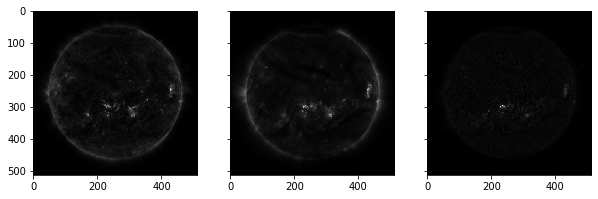

In [8]:
# just selecting one single image at random
#a way to check the shape is as expected and the loader works
for batch_index, batch in enumerate(train_data_loader):
    print(batch_index, batch.shape)
    fig, ax = plt.subplots(1, 3, figsize=(10,10), sharey=True)
    for i in range(len(channels)):
        print(channels[i])
        item = batch[4,i,:,:]
        print(torch.max(item), torch.min(item))
        print(item)
        print(item.cpu().numpy().max(), item.cpu().numpy().min(), item.cpu().numpy().std(), np.median(item.cpu().numpy()))
        ax[i].imshow(batch[4,i,:,:].cpu().numpy(), cmap='gray')
    break

Since it seems to work we can try to run it on a simple model.

In [9]:
# initializaion of DNN model and parameters
model = AutoEncoder(input_shape=[len(channels), img_shape,img_shape])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

Autoencoder architecture:
Input shape: [3, 512, 512]
Input dim  : 786432
Encoded dim: 57600
Hidden dim : 512
Learnable params: 59669699


In [10]:
# training loop
model.cuda(cuda_device)
len_data = train_data.__len__()
log_interval = 10
n_epochs = 4
train_loss = []
for epoch in range(n_epochs):
    for batch_index, batch in enumerate(train_data_loader):
        data = batch.to(cuda_device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        train_loss.append(float(loss))
        loss.backward()
        optimizer.step()
        if batch_index % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_index * len(data), len_data, 
                100.*(batch_index* len(data)) / len_data, 
                loss.item() / len(data)))

Train Epoch: 0 [0/1664 (0%)]	Loss: 0.018299
Train Epoch: 0 [100/1664 (6%)]	Loss: 0.010456
Train Epoch: 0 [200/1664 (12%)]	Loss: 0.005745
Train Epoch: 0 [300/1664 (18%)]	Loss: 0.005452
Train Epoch: 0 [400/1664 (24%)]	Loss: 0.007377
Train Epoch: 0 [500/1664 (30%)]	Loss: 0.007483
Train Epoch: 0 [600/1664 (36%)]	Loss: 0.007044
Train Epoch: 0 [700/1664 (42%)]	Loss: 0.005134
Train Epoch: 0 [800/1664 (48%)]	Loss: 0.006246
Train Epoch: 0 [900/1664 (54%)]	Loss: 0.004840
Train Epoch: 0 [1000/1664 (60%)]	Loss: 0.003950
Train Epoch: 0 [1100/1664 (66%)]	Loss: 0.003965
Train Epoch: 0 [1200/1664 (72%)]	Loss: 0.003173
Train Epoch: 0 [1300/1664 (78%)]	Loss: 0.004339
Train Epoch: 0 [1400/1664 (84%)]	Loss: 0.002684
Train Epoch: 0 [1500/1664 (90%)]	Loss: 0.003715
Train Epoch: 0 [1600/1664 (96%)]	Loss: 0.003470
Train Epoch: 1 [0/1664 (0%)]	Loss: 0.003407
Train Epoch: 1 [100/1664 (6%)]	Loss: 0.002546
Train Epoch: 1 [200/1664 (12%)]	Loss: 0.003126
Train Epoch: 1 [300/1664 (18%)]	Loss: 0.003437
Train Epoch: 1

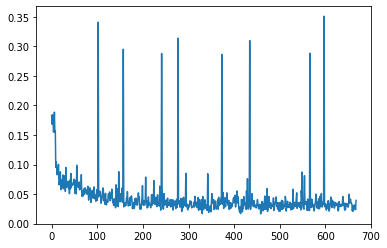

Loss min: 0.016453970223665237, max: 0.3507980704307556, mean: 0.044008966945223285


In [11]:
# there are some spikes in the loss function, probably related to the high intensity pixels that still exist 
# after the normalization "by mean that we are applying"
plt.plot(train_loss, label='training loss');
plt.show();
print('Loss min: {}, max: {}, mean: {}'.format(min(train_loss), max(train_loss), np.mean(train_loss)))

In [24]:
test_data_loader = DataLoader(test_data, batch_size=100, shuffle=True)

In [25]:
#test loop
len_data = test_data.__len__()
log_interval = 10
test_loss = []

for batch_index, batch in enumerate(test_data_loader):
    data = batch.to(cuda_device)
    recon_batch = model(data)
    loss = loss_function(recon_batch, data)
    test_loss.append(float(loss))
    if batch_index % log_interval == 0:
        print('Progress: {} , Test Loss: {:.6f}'.format(
            100.*(batch_index* len(data)) / len_data, loss.item() / len(data)))

RuntimeError: CUDA out of memory. Tried to allocate 3.10 GiB (GPU 1; 15.75 GiB total capacity; 11.25 GiB already allocated; 2.33 GiB free; 1.10 GiB cached; 0 bytes inactive)

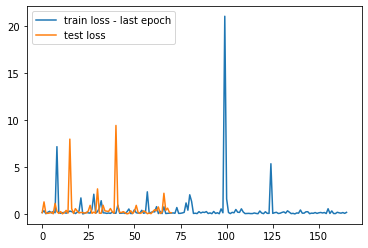

Loss min: 0.03850514814257622, max: 9.443086624145508, mean: 0.5982576865755337


In [27]:
plt.plot(train_loss[-int(train_data.__len__()/10):], label='train loss - last epoch');
plt.plot(test_loss, label='test loss');
plt.legend()
plt.show();
print('Loss min: {}, max: {}, mean: {}'.format(min(test_loss), max(test_loss), np.mean(test_loss)))